In [1]:
import torch.nn as nn
import torch
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import tqdm
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

class SpatialGatingUnit(nn.Module):

  def __init__(self, d_ffn, seq_len):
    super(SpatialGatingUnit, self).__init__()

    self.normalization = nn.LayerNorm(d_ffn // 2)
    self.spatial_projection = nn.Linear(seq_len, seq_len)
    # weights are initialized as close to zero and biases as one
    weights = torch.empty((seq_len, seq_len))
    nn.init.xavier_uniform_(weights)
    weights *= 0.001
    nn.init.ones_(self.spatial_projection.bias)


  def forward(self, x):
    u, v = x.chunk(2, dim=-1) # split x into two equal parts u and v along the channel axis
    v = self.normalization(v) # perform layer normalization to v
    v = v.permute(0, 2, 1) # change the channel with the spatial dimension for v
    v = self.spatial_projection(v) # perform spatial projection
    v = v.permute(0, 2, 1) # change the channel with the spatial dimension back to normal
    return u * v # return the product of the element-wise multiplicated tensors

In [3]:
# class definition of an gMLP block
class gMLPBlock(nn.Module):

  def __init__(self, d_model, d_ffn, seq_len, dropout_prob):
    super(gMLPBlock, self).__init__()

    self.normalization = nn.LayerNorm(d_model)
    self.projection = nn.Linear(d_model, d_ffn)
    self.activation = nn.GELU()
    self.spatial_gating_unit = SpatialGatingUnit(d_ffn, seq_len)
    self.projection2 = nn.Linear(d_ffn // 2, d_model)
    self.dist = torch.distributions.bernoulli.Bernoulli(torch.Tensor([dropout_prob]))

  def forward(self, x):
    if self.training and torch.equal(self.dist.sample(), torch.zeros(1)):
      return x # if network is training perform dropout with the given probability
    shortcut = x # save copy of x for the shortcut
    x = self.normalization(x) # perform normalization
    x = self.projection(x) # perform projection from d_model to d_ffn along channels
    x = self.activation(x) # perform gelu activation
    x = self.spatial_gating_unit(x) # perform spatial gating unit
    x = self.projection2(x) # peform projection from d_ffn/2 to d_model along channels
    return x + shortcut # add shortcut

In [4]:
# class definition of the gMLP model
class gMLP(nn.Module):

  def __init__(self, d_model, d_ffn, seq_len, lx, dropout_probs):
    super(gMLP, self).__init__()

    self.dropout_probs = torch.linspace(dropout_probs[0], dropout_probs[1], lx)
    self.blocks = nn.Sequential(*[gMLPBlock(d_model, d_ffn, seq_len, dropout_prob) for dropout_prob in self.dropout_probs])

  def forward(self, x):
    x = self.blocks(x) # perform lx sequential blocks of gmlp
    return x

In [5]:
class gMLPImage(nn.Module):

  def __init__(self, d_model, d_ffn, lx, patch_size, image_size, channels, classes, dropout_probs):
    super(gMLPImage, self).__init__()
    self.seq_len = (image_size // patch_size) ** 2
    self.patch_embedding = nn.Conv2d(channels, d_model, kernel_size=patch_size, stride=patch_size)
    self.gmlp = gMLP(d_model, d_ffn, self.seq_len, lx, dropout_probs)
    self.output = nn.Linear(d_model, classes)

  def forward(self, x):
    x = self.patch_embedding(x) # do the patch embedding via a 2d conv
    x = x.permute(0, 2, 3, 1)  # rearrange dimensions to (batch_size, height, width, channels)
    x = x.contiguous().view(x.size(0), -1, x.size(-1))  # flattening into a single dimension of shape (batch_size, height*width, channels)
    x = self.gmlp(x) # perform gmlp
    x = x.mean(1) # perform global average pooling
    x = self.output(x) # perform projection onto the desired number of output classes
    return x

In [36]:
epochs = 10                 # number of epochs to complete
d_model = 220               # d_model
d_ffn = 900                 # d_ffn
lx = 6                      # number of blocks to be sequentially executed
patch_size = 16              # patch size for patch embedding convolution
image_size = 128            # size of the input images (must be square)
classes = 19                # number of output classes
channels = 3                # number of input channels (in our case rgb)
dropout_probs = [0.9, 0.9]  # first and last value of droput probabilities that are used to created a linspace with a dropout prob for each block
batch_size = 16             # batch size for the gradient descent
eval_ratio = 0.2            # ratio of dataset used for validation

In [37]:
# Evaluate the model on the test dataset
def evaluate_model(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm.tqdm(loader, desc="Evaluation"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return accuracy, precision, recall, conf_matrix

In [38]:
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [39]:

loss_fn = nn.CrossEntropyLoss()

def loop_vm(net, loader, opt, is_train):
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm.tqdm(loader, total=len(loader))
    for x, y in pbar:
        x = x.to(device) 
        y = y.to(device)
        
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc.item())
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        if is_train:
          pbar.set_description(f'Training  : Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')
        else:
          pbar.set_description(f'Validation: Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')

In [40]:
gmlp = gMLPImage(d_model = d_model,
                 d_ffn = d_ffn,
                 lx = lx,
                 patch_size = patch_size,
                 image_size = image_size,
                 channels = channels,
                 classes = classes,
                 dropout_probs = dropout_probs
                 ).to(device)

In [41]:
from torchvision import transforms, datasets
T = transforms.Compose([transforms.Resize((image_size, image_size)),transforms.ToTensor()])

train = datasets.ImageFolder('./GroceryStoreDataset-master/dataset/train/Fruit', transform=T)
test = datasets.ImageFolder('./GroceryStoreDataset-master/dataset/test/Fruit', transform=T)
val = datasets.ImageFolder('./GroceryStoreDataset-master/dataset/val/Fruit', transform=T)

class_names =train.classes
# Get one batch of images and labels

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

In [42]:
images, labels = next(iter(train_loader))

# Print the shapes
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

Images shape:  torch.Size([16, 3, 128, 128])
Labels shape:  torch.Size([16])


In [43]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [44]:
opt = torch.optim.Adam(gmlp.parameters()) # set optimizer to the adam optimizer

for epoch in range(epochs):
    loop_vm(gmlp, train_loader, opt, True)
    loop_vm(gmlp, val_loader, opt, False)

Training  : Epoch: 6 Loss: 1.3080 Acc: 0.5689:  81%|████████  | 58/72 [00:08<00:01, 11.41it/s]

: 

Evaluation: 100%|██████████| 70/70 [00:10<00:00,  6.66it/s]


Test Accuracy: 40.82%
Test Precision: 40.82%
Test Recall: 40.82%


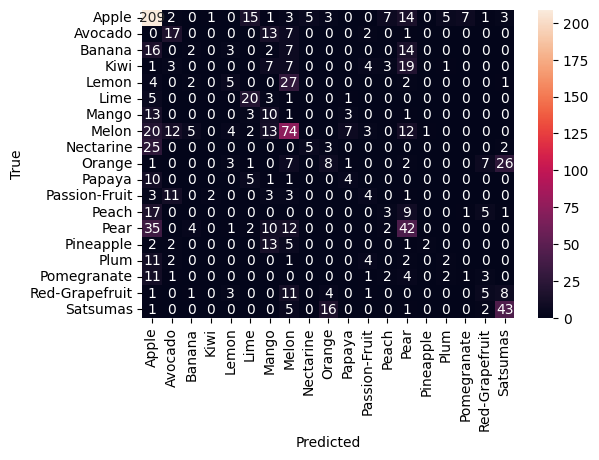

In [25]:


test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()